In [1]:
import matplotlib.pyplot as plt
from t4gpd.io.CirReader import CirReader
from t4gpd.pyvista.ToUnstructuredGrid import ToUnstructuredGrid
from shapely.geometry import Polygon
from geopandas import GeoDataFrame
import numpy as np
import pandas as pd
import geopandas
from math import *
from numpy.random import randint
from shapely.geometry import LineString,Point
from t4gpd.commons.GeomLib import GeomLib
from t4gpd.demos.GeoDataFrameDemos import GeoDataFrameDemos
from t4gpd.morph.geoProcesses.FootprintExtruder import FootprintExtruder
from t4gpd.morph.geoProcesses.STGeoProcess import STGeoProcess
from t4gpd.morph.STPointsDensifier2 import STPointsDensifier2
from t4gpd.pyvista.ToUnstructuredGrid import ToUnstructuredGrid
import random
from t4gpd.commons.RayCasting3Lib import RayCasting3Lib
import timeit
from matplotlib.gridspec import GridSpec
from pandas import concat,merge
from t4gpd.pyvista.commons.RayCasting3DLib import RayCasting3DLib
from t4gpd.pyvista.geoProcesses.RayCasting3D import RayCasting3D
from t4gpd.pyvista.STRaysToViewFactors import STRaysToViewFactors
from t4gpd.pyvista.geoProcesses.MoveSensorsAwayFromSurface import MoveSensorsAwayFromSurface

# Functions

In [2]:
def SurfaceNormal(self): #input is the buildingsIn3d.geometry[i],than choose the polygon of one facet
    coord = self.exterior.coords
    facet_p0=np.array(coord[0])
    facet_p1=np.array(coord[1])
    facet_p2=np.array(coord[2])
    vec1 = facet_p1 - facet_p0
    vec2 = facet_p2 - facet_p1
    a = vec1[1]*vec2[2]-vec1[2]*vec2[1]
    b = vec1[2]*vec2[0]-vec1[0]*vec2[2]
    c = vec1[0]*vec2[1]-vec1[1]*vec2[0]
    normal = np.array([a,b,c])
    mod = module(normal)
    n  = normal/mod
    return n

In [3]:
def module(vector):
    return np.sqrt(np.dot(np.array(vector),np.array(vector)))

In [4]:
def VectorAngleCos(vector1,vector2):#calculate the angle between two vectors
    unit_vector1 = vector1/np.linalg.norm(vector1)
    unit_vector2 = vector2/np.linalg.norm(vector2)
    dot_vector = np.dot(unit_vector1,unit_vector2)
    return dot_vector

In [5]:
def STEvenPoints(face,n,m): #row=n, column=m
    p = face.exterior.coords
    vec1 = np.array(p[2])-np.array(p[1])
    vec2 = np.array(p[1])-np.array(p[0])
    L1 = vec1/n
    L2 = vec2/m
    s = []
    normal = []
    for i in range(1,n+1):
        for j in range(1,m+1):
            point_1 = np.array(p[0])+L2*(j-1)+L1*(i-1)
            point_2 = np.array(p[0])+L2*j+L1*i
            point_c = Point((point_1+point_2)/2)
            s.append(point_c)
            normal.append(SurfaceNormal(face))
    p_geodata = GeoDataFrame({'geometry':s},crs='epsg:2154')
    p_geodata['NormalVector'] = normal
    return p_geodata

In [6]:
def SelectRay(vec0,vec1,ray,method):#transform into 2d
    if method=='horizontal':
        v0 = np.array([vec0[0],vec0[1]])#here v0 is the left point
        v1 = np.array([vec1[0],vec1[1]])
        r = np.array([ray[0],ray[1]])
    if method=='vertical':
        v0 = np.array([vec0[1],vec0[2]])#here v0 is the taller point
        v1 = np.array([vec1[1],vec1[2]])
        r = np.array([ray[1],ray[2]])

    x = v0[0]*r[1]-v0[1]*r[0]
    y = v1[0]*r[1]-v1[1]*r[0]
    if x<=0 and y>=0:
        return True
    else:
        return False

In [7]:
def OnSurface(self,point):
    ang = 0
    p = np.array(point)
    coord = self.exterior.coords
    for i in range(len(coord)-1):
        vec1 = np.array(coord[i]) - p
        vec2 = np.array(coord[i+1])-p
        m1 = module(vec1)
        m2 = module(vec2)
        if cmp(m1*m2,0):
            return True
        else:
            cost = np.dot(vec1,vec2)/(m1*m2)
        if cost>1:
            cost = 1
        if cost<-1:
            cost = -1
        ang = ang +np.arccos(cost)
    return cmp(ang,2*np.pi)

In [8]:
def centroid(self): #rectangle centroid
    coord = self.exterior.coords
    face_p0=np.array(coord[0])
    face_p2=np.array(coord[2])
    face_ce=(face_p0+face_p2)/2
    return Point(face_ce)

In [9]:
def intersection(ray,sensor,surface):
    n = SurfaceNormal(surface)
    coords = surface.exterior.coords
    point = np.array(sensor.geometry)
    vec = np.array(coords[1])-point
    con1 = ray.dot(n)
    con2 = vec.dot(n)
    ratio = con2/con1
    if con1>0:
        return False
    else:
        in_point = point + ratio*ray
        if OnSurface(surface,Point(in_point)):
            return ratio
        else:
            return False  

In [10]:
def grid3d(self,n,m):#n rows, m columns
    coord = self.exterior.coords
    p0=np.array(coord[0])
    p1=np.array(coord[1])
    p2=np.array(coord[2])
    p3=np.array(coord[3])
    vec1 = (p1-p0)/m
    vec2 = (p2-p1)/n
    poly=[]
    cen_p=[]
    sur_area=[]
    normal=[]
    sur_d=[]
    for i in range(n):
        for j in range(m):
            p0_t=Point(p0+j*vec1+i*vec2)
            p1_t=Point(p0+(j+1)*vec1+i*vec2)
            p2_t=Point(p0+(j+1)*vec1+(i+1)*vec2)
            p3_t=Point(p0+j*vec1+(i+1)*vec2)
            face_t = Polygon([p0_t,p1_t,p2_t,p3_t,p0_t])
            poly.append(face_t)
            cen_p.append(centroid(face_t))
            sur_area.append(area3d(face_t))
            normal.append(SurfaceNormal(face_t))
            sur_d.append(Surface_diameter(face_t))
    self_grid=GeoDataFrame({'geometry': poly},crs='epsg:2154')
    self_grid['CentroidPoint']=cen_p
    self_grid['area']=sur_area
    self_grid['NormalVector']=normal
    self_grid['diameter']=sur_d
    return self_grid

In [11]:
def cmp(a,b,c=1e-3):
    return abs(a-b)<c

In [12]:
def Surface_diameter(surface):
    coord = surface.exterior.coords
    d = distance3d(Point(coord[0]),Point(coord[2]))
    return d

In [13]:
def RayPoint2(point,n,norm,length):
    ray_line = []
    vec = RandomDir(n)
    for i in range(len(vec)):
        vec1 = vec[i]
        x2 = norm[0]*vec1[1]+norm[1]*vec1[0]
        y2 = norm[1]*vec1[1]-norm[0]*vec1[0]
        z2 = vec1[2]
        p2 = Point(point.x+x2*length,point.y+y2*length,point.z+z2*length)
        ray_vec = np.array([p2.x,p2.y,p2.z]) - np.array([point.x,point.y,point.z])
        ray_line.append(ray_vec)
    return ray_line

In [14]:
def distance3d(point1,point2):
    d = sqrt((point1.x-point2.x)**2 + (point1.y-point2.y)**2 + (point1.z-point2.z)**2)
    return d

In [15]:
def RandomDir(n):#number of samples
    vector = []
    for i in range(n):
        polar = 0.5*np.arccos(1-2*random.random())
        azimuth = random.random()*pi*2
        x = cos(polar)*sin(azimuth)
        y = sin(polar)
        z = cos(polar)*cos(azimuth)
        vector.append(np.array([x,y,z]))
    return vector

In [16]:
#get area from 3d polygon
def area3d(self):
    coord = self.exterior.coords
    d1 = distance3d(Point(coord[0]),Point(coord[1]))
    d2 = distance3d(Point(coord[1]),Point(coord[2]))
    return d1*d2

In [17]:
def vf_nusselt(face1,face2): #emitting from face1 accept by face2
    pt1 = face1.CentroidPoint
    pt2 = face2.CentroidPoint
    n1 = face1.NormalVector
    n2 = face2.NormalVector
    vec = np.array(pt2)-np.array(pt1)
    a2 = face2.area
    r = distance3d(pt1,pt2)
    vf = -a2*VectorAngleCos(n1,vec)*VectorAngleCos(n2,vec)/(pi*r**2)
    return vf

In [18]:
def vf_nusselt2(face1,face2): #emitting from face1 accept by face2
    pt1 = face1.CentroidPoint
    pt2 = face2.CentroidPoint
    n1 = face1.NormalVector
    n2 = face2.NormalVector
    vec = np.array(pt2)-np.array(pt1)
    a2 = face2.area
    r = distance3d(pt1,pt2)
    vf = -a2*VectorAngleCos(n2,vec)/(2*pi*r**2)
    return vf

In [19]:
def CreateFaces(x,y,method): #x=w/d, y=h/d
    k = y/x
    polygon1 = []
    polygon2 = []
    coords_3d_1 = np.array([[10,0,0], [0,0,0], [0,0,10*k], [10,0,10*k], [10,0,0]])
    if method == 'parallel':
        coords_3d_2 = np.array([[0,10/x,0], [10,10/x,0], [10,10/x,10*k], [0,10/x,10*k], [0,10/x,0]])
    elif method == 'vertical':
        coords_3d_2 = np.array([[0,0,0], [10,0,0], [10,10/x,0], [0,10/x,0], [0,0,0]])
    else:
        return 'Please select your method "parallel" or "vertical"?'
    polygon1.append(Polygon(coords_3d_1))
    polygon2.append(Polygon(coords_3d_2))
    f1 = GeoDataFrame({'geometry':polygon1},crs='epsg:2154')
    f2 = GeoDataFrame({'geometry':polygon2},crs='epsg:2154')
    
    f1['area'] = area3d(f1.geometry.iloc[0])
    f2['area'] = area3d(f2.geometry.iloc[0])
    
    f1['diameter'] = Surface_diameter(f1.geometry.iloc[0])
    f2['diameter'] = Surface_diameter(f2.geometry.iloc[0])
    
    f1['CentroidPoint'] = centroid(f1.geometry.iloc[0])
    f2['CentroidPoint'] = centroid(f2.geometry.iloc[0])
    return f1,f2

In [385]:
def CreateFaces_share(theta): #x=w/d, y=h/d
    polygon1 = []
    polygon2 = []
    coords_3d_1 = np.array([[10,0,0], [0,0,0], [0,0,10], [10,0,10], [10,0,0]])
    coords_3d_2 = np.array([[0,0,0], [10,0,0], [10,10*sin(theta),10*cos(theta)], [0,10*sin(theta),10*cos(theta)], [0,0,0]])

    polygon1.append(Polygon(coords_3d_1))
    polygon2.append(Polygon(coords_3d_2))
    f1 = GeoDataFrame({'geometry':polygon1},crs='epsg:2154')
    f2 = GeoDataFrame({'geometry':polygon2},crs='epsg:2154')
    
    f1['area'] = area3d(f1.geometry.iloc[0])
    f2['area'] = area3d(f2.geometry.iloc[0])
    
    f1['diameter'] = Surface_diameter(f1.geometry.iloc[0])
    f2['diameter'] = Surface_diameter(f2.geometry.iloc[0])
    
    f1['CentroidPoint'] = centroid(f1.geometry.iloc[0])
    f2['CentroidPoint'] = centroid(f2.geometry.iloc[0])
    return f1,f2

In [20]:
def ParallelVF(a,b):#a=width/distance,b=height/distance
    f = 2/(pi*a*b)*(log(((1+a**2)*(1+b**2)/(1+a**2+b**2))**0.5)+
                    (a*(1+b**2)**0.5)*atan(a/(1+b**2)**0.5)+
                    (b*(1+a**2)**0.5)*atan(b/(1+a**2)**0.5)-
                    a*atan(a)-
                    b*atan(b))
    return f

In [21]:
#Subdivide function 2
def Subdivide2(f1,f2): #f1 is the emitting surface, f2 is the target surface
    if isFiveTimeRuleOk(f1,f2):
        return [f1]
    else:
        d = distance3d(f1.CentroidPoint,f2.CentroidPoint)/5
        coord1 = f1.geometry.exterior.coords
        w1 = distance3d(Point(coord1[0]),Point(coord1[1]))
        h1 = distance3d(Point(coord1[1]),Point(coord1[2]))
        
        n1 = int(h1/d)+1
        m1 = int(w1/d)+1
        
        return grid3d(f1.geometry,n1,m1)

In [22]:
def Subdivide(f1,f2): #f1 is the emitting surface, f2 is the target surface
    if isFiveTimeRuleOk(f1,f2):
        return [f1]
    else:
        result = []
        f_grid = grid3d(f1.geometry,2,2)
        for i in range(len(f_grid)):
            if isFiveTimeRuleOk(f_grid.iloc[i],f2):
                result.append(f_grid.iloc[i])
            else:
                result += Subdivide(f_grid.iloc[i],f2)
        return result

In [23]:
def isFiveTimeRuleOk(f1,f2):
    return distance3d(f1.CentroidPoint,f2.CentroidPoint) >= 5*f1.diameter

In [24]:
def isa(face1,face2):#view factor from 1 to 2
    n1=SurfaceNormal(face1.geometry)
    n2=SurfaceNormal(face2.geometry)
    a2=area3d(face2.geometry)
    vec_R=np.array([face1.CentroidPoint.x-face2.CentroidPoint.x,face1.CentroidPoint.y-face2.CentroidPoint.y,face1.CentroidPoint.z-face2.CentroidPoint.z])
    vf=-a2*np.dot(n1,vec_R)*np.dot(n2,vec_R)/(pi*module(vec_R)**4)
    return vf

In [25]:
def MonteCarlo(f1,f2,nb_ray,n,m,times):
    sensors = STEvenPoints(f1.geometry[0],n,m)
    sensors['NormalVector'] = [SurfaceNormal(f1.geometry[0]) for item in sensors.geometry]
    coords = f2.geometry[0].exterior.coords

    nb_cal = []
    for w in range(times):
        nb=0
        for s in range(len(sensors)):
            p = sensors.iloc[s]
            normal = p.NormalVector
            ray = RayPoint2(p.geometry,nb_ray,normal,20)
            f2['nray'] = 0
            point = np.array(p.geometry)
            vec0 = np.array(coords[0])-point
            vec1 = np.array(coords[1])-point
            vec2 = np.array(coords[2])-point
            ray_vec = []
            for j in range(len(ray)):
                if SelectRay(vec0,vec1,ray[j],'horizontal')==True and SelectRay(vec2,vec1,ray[j],'vertical')==True:
                    ray_vec.append(ray[j])
            for a in range(len(ray_vec)):
                ratio = []
                value = intersection(ray_vec[a],p,f2.geometry[0])
                if value==False:
                    ratio.append(0)
                else:
                    ratio.append(value)
                f2['ratio'] = ratio
                mymin = min(f2.ratio)
                if f2.ratio[0]!=0:
                    f2.loc[0,'nray'] = f2.loc[0,'nray']+1
            nbs = f2.nray
            nb = nb + nbs
        nb_cal.append(nb/(len(sensors)*nb_ray))
    vf = np.mean(nb_cal)
    
    return vf

In [443]:
def newMonteCarlo(f1,f2,nb_ray,n,m,times):
    g1 = grid3d(f1.geometry.squeeze(),n,m)
    g2 = grid3d(f2.geometry.squeeze(),n,m)
    masks = concat([g1,g2])
    masks.reset_index(inplace=True, drop=True)
    masks['pk'] = masks.index
    
    sensors = GeoDataFrame({'geometry':list(masks.CentroidPoint)},crs='epsg:2154')
    sensors['NormalVector'] = list(masks.NormalVector)
    sensors['pk'] = list(masks.pk)
    op1 = MoveSensorsAwayFromSurface(sensors,normalFieldname='NormalVector',dist=1e-6)
    sensors = STGeoProcess(op1,sensors).execute()
    
    viewfactor = []
    
    coords = f2.geometry[0].exterior.coords#selectray
    
    for w in range(times):
        vf = []
        #shootingDirs = RayCasting3DLib.preparePanopticRays(nb_ray)
        ray = RayPoint2(sensors.geometry.iloc[0],nb_ray,sensors.NormalVector.iloc[0],1)
        for i in range(int(len(sensors)/2)):
            sensor = sensors.loc[ sensors[sensors.pk == i].index ]
            
            #select ray
            point = np.array(sensor.geometry.squeeze())
            vec0 = np.array(coords[0])-point
            vec1 = np.array(coords[1])-point
            vec2 = np.array(coords[2])-point
            ray_vec = []
            for j in range(len(ray)):
                #if SelectRay(vec2,vec0,ray[j],'vertical')==True:
                ray_vec.append(ray[j])
            shootingDirs = np.asarray(ray_vec)
            
            #calculate viewfactor
            op2 = RayCasting3D([masks], shootingDirs, viewpoints=sensor,
                      normalFieldname='NormalVector', pkFieldname='pk')
            rays = STGeoProcess(op2, sensor).execute()
            vfSparseMatrix = STRaysToViewFactors(rays,'pk','hitGids').run()
            vf.append(sum(vfSparseMatrix.viewfactor)*len(ray_vec)/len(ray))
        viewfactor.append(sum(vf)/(len(sensors)/2))
    return np.mean(viewfactor)

In [27]:
def dci(f1,f2,n,m):
    g1 = grid3d(f1.geometry.squeeze(),n,m)
    g2 = grid3d(f2.geometry.squeeze(),n,m)
    for i in range(len(g1)):
        for j in range(len(g2)):
            R = distance3d(g1.CentroidPoint.iloc[i],g2.CentroidPoint.iloc[j])
            

In [28]:
def VerticalVF(a,b):#a = h/w , b = l/w
    f = 1/(pi*b)*(b*atan(1/b)+a*atan(1/a)-((a**2+b**2)**0.5)*atan(1/((a**2+a**2)**0.5))+0.25*log((1+b**2)*(1+a**2)/(1+b**2+a**2)*((b**2*(1+b**2+a**2)/((1+b**2)*(b**2+a**2)))**(b**2))*(a**2*(1+a**2+b**2)/((1+a**2)*(a**2+b**2)))**(a**2)))
    return f

In [77]:
def rotation(f1,theta):#counterclockwise
    self = f1.geometry.squeeze()
    coord = self.exterior.coords
    p_cen = f1.CentroidPoint.squeeze()
    x0 = (Point(coord[0]).x-p_cen.x)*cos(theta)-(Point(coord[0]).y-p_cen.y)*sin(theta)+p_cen.x
    y0 = (Point(coord[0]).y-p_cen.y)*cos(theta)+(Point(coord[0]).x-p_cen.x)*sin(theta)+p_cen.y
    x1 = (Point(coord[1]).x-p_cen.x)*cos(theta)-(Point(coord[1]).y-p_cen.y)*sin(theta)+p_cen.x
    y1 = (Point(coord[1]).y-p_cen.y)*cos(theta)+(Point(coord[1]).x-p_cen.x)*sin(theta)+p_cen.y
    p0 = Point(x0,y0,Point(coord[0]).z)
    p1 = Point(x1,y1,Point(coord[1]).z)
    p2 = Point(x1,y1,Point(coord[2]).z)
    p3 = Point(x0,y0,Point(coord[3]).z)
    face = Polygon([p0,p1,p2,p3,p0])
    f1['geometry']= face
    return f1

# Thress methods

In [265]:
#L1 = [1,0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1]
#L1 = [2,1.9,1.8,1.7,1.6,1.5,1.4,1.3,1.2,1.1]
#L1 = [6,5,4,3,2,1]
L1 =[10]

In [259]:
#Nusselt analogue
error = []
time = []
vf = []
vf_a = []
for n in range(len(L1)):
    vf2 = []
    start = timeit.default_timer()
    f1,f2 = CreateFaces(L1[n],L1[n],'parallel')
    f1_grid = grid3d(f1.geometry.squeeze(),10,10)
    f2_grid = grid3d(f2.geometry.squeeze(),10,10)
    for i in f2_grid.iloc():
        vf3=[]
        for j in f1_grid.iloc():
            vf3.append(vf_nusselt(j,i))
        vf2.append(sum(vf3)/len(f1_grid))
    vf.append(sum(vf2))
    stop = timeit.default_timer()
    vf_a.append(ParallelVF(L1[n],L1[n]))
    error.append((sum(vf2)-ParallelVF(L1[n],L1[n]))/ParallelVF(L1[n],L1[n])*100)
    time.append(stop-start)

In [264]:
time

[2.715750100032892]

In [223]:
#isa method
error2 = []
time2 = []
vf2 = []
vf_a = []
for j in range(len(L1)):
    start = timeit.default_timer()
    f1,f2 = CreateFaces(L1[j],L1[j],'parallel')
    d = GeoDataFrame(Subdivide2(f1.iloc[0],f2.iloc[0]))
    c = GeoDataFrame(Subdivide2(f2.iloc[0],f1.iloc[0]))
    vftest = 0
    for i in range(len(d)):
        face_0 = d.iloc[i]
        vf2_isa = [isa(face_0,face_1) for face_1 in c.iloc]
        vftest = vftest + sum(vf2_isa)/len(d)
    vf2.append(vftest)
    vf_a.append(ParallelVF(L1[j],L1[j]))
    stop = timeit.default_timer()
    error2.append((vftest-ParallelVF(L1[j],L1[j]))/ParallelVF(L1[j],L1[j])*100)
    time2.append(stop-start)

In [40]:
#Monte Carlo Ray Tracing
n = 5
m = 5
times = 5
n_ray = 1000
vf3 = []
time3 = []
error3 = []
for j in range(len(L1)):
    start = timeit.default_timer()
    f1,f2 = CreateFaces(L1[j],L1[j],'parallel')
    vf_mc = MonteCarlo(f1,f2,n_ray,n,m,times)
    vf3.append(vf_mc)
    stop = timeit.default_timer()
    error3.append((vf_mc-ParallelVF(L1[j],L1[j]))/ParallelVF(L1[j],L1[j])*100)
    time3.append(stop-start)

In [266]:
#new Monte Carlo Ray Tracing
n = 5
m = 5
times = 5
n_ray = 1000
vf4 = []
time4 = []
error4 = []
for j in range(len(L1)):
    start = timeit.default_timer()
    f1,f2 = CreateFaces(L1[j],L1[j],'parallel')
    vf_mc = newMonteCarlo(f1,f2,n_ray,n,m,times)
    vf4.append(vf_mc)
    stop = timeit.default_timer()
    error4.append((vf_mc-ParallelVF(L1[j],L1[j]))/ParallelVF(L1[j],L1[j])*100)
    time4.append(stop-start)

Elapsed time: 0.007 s (00:00:00)
Elapsed time: 0.023 s (00:00:00)
Elapsed time: 0.036 s (00:00:00)
Elapsed time: 0.024 s (00:00:00)
Elapsed time: 0.024 s (00:00:00)
Elapsed time: 0.023 s (00:00:00)
Elapsed time: 0.027 s (00:00:00)
Elapsed time: 0.027 s (00:00:00)
Elapsed time: 0.032 s (00:00:00)
Elapsed time: 0.044 s (00:00:00)
Elapsed time: 0.027 s (00:00:00)
Elapsed time: 0.027 s (00:00:00)
Elapsed time: 0.052 s (00:00:00)
Elapsed time: 0.031 s (00:00:00)
Elapsed time: 0.051 s (00:00:00)
Elapsed time: 0.027 s (00:00:00)
Elapsed time: 0.025 s (00:00:00)
Elapsed time: 0.026 s (00:00:00)
Elapsed time: 0.030 s (00:00:00)
Elapsed time: 0.026 s (00:00:00)
Elapsed time: 0.054 s (00:00:00)
Elapsed time: 0.022 s (00:00:00)
Elapsed time: 0.023 s (00:00:00)
Elapsed time: 0.027 s (00:00:00)
Elapsed time: 0.028 s (00:00:00)
Elapsed time: 0.023 s (00:00:00)
Elapsed time: 0.025 s (00:00:00)
Elapsed time: 0.025 s (00:00:00)
Elapsed time: 0.024 s (00:00:00)
Elapsed time: 0.024 s (00:00:00)
Elapsed ti

# Result

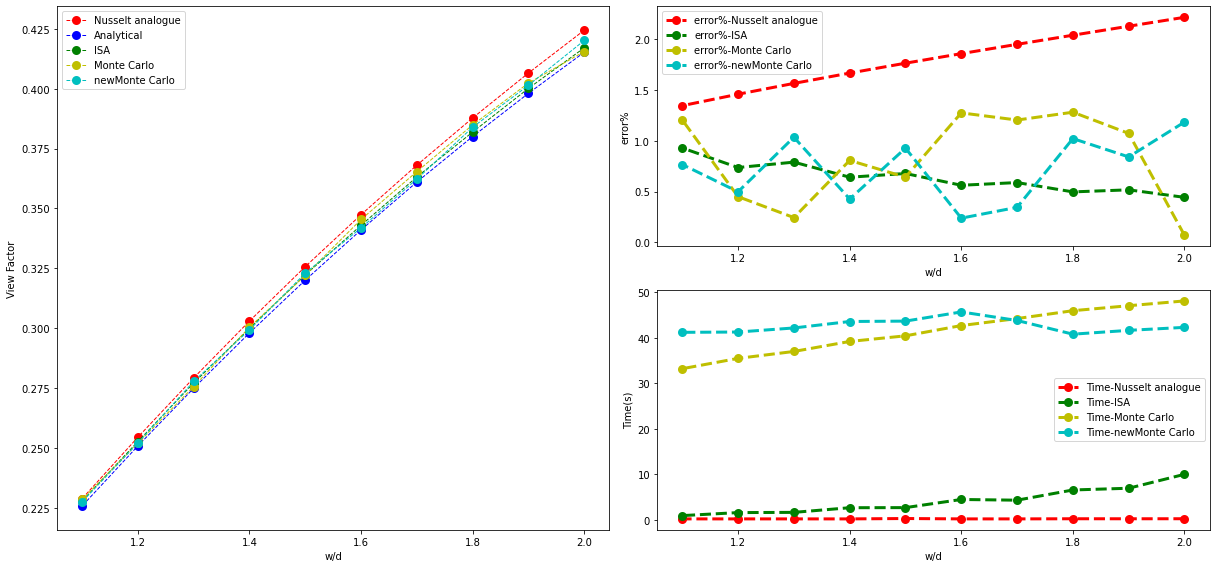

In [42]:
fig = plt.figure(figsize=(17,8))
gs = GridSpec(nrows=2,ncols=2)

ax0 = fig.add_subplot(gs[:,0])
ax0.plot(L1,vf,'r--',label = 'Nusselt analogue',linewidth=1,marker='o',markeredgewidth=3)
ax0.plot(L1,vf_a,'b--',label = 'Analytical',linewidth=1,marker='o',markeredgewidth=3)
ax0.plot(L1,vf2,'g--',label = 'ISA',linewidth=1,marker='o',markeredgewidth=3)
ax0.plot(L1,vf3,'y--',label = 'Monte Carlo',linewidth=1,marker='o',markeredgewidth=3)
ax0.plot(L1,vf4,'c--',label = 'newMonte Carlo',linewidth=1,marker='o',markeredgewidth=3)
ax0.set(xlabel='w/d',ylabel='View Factor')
plt.legend()

ax1 = fig.add_subplot(gs[0,1])
ax1.plot(L1,error,'r--',label = 'error%-Nusselt analogue',linewidth=3,marker='o',markeredgewidth=3)
ax1.plot(L1,error2,'g--',label = 'error%-ISA',linewidth=3,marker='o',markeredgewidth=3)
ax1.plot(L1,error3,'y--',label = 'error%-Monte Carlo',linewidth=3,marker='o',markeredgewidth=3)
ax1.plot(L1,error4,'c--',label = 'error%-newMonte Carlo',linewidth=3,marker='o',markeredgewidth=3)
ax1.set(xlabel='w/d',ylabel='error%')
plt.legend()

ax2 = fig.add_subplot(gs[1,1])
ax2.plot(L1,time,'r--',label = 'Time-Nusselt analogue',linewidth=3,marker='o',markeredgewidth=3)
ax2.plot(L1,time2,'g--',label = 'Time-ISA',linewidth=3,marker='o',markeredgewidth=3)
ax2.plot(L1,time3,'y--',label = 'Time-Monte Carlo',linewidth=3,marker='o',markeredgewidth=3)
ax2.plot(L1,time4,'c--',label = 'Time-newMonte Carlo',linewidth=3,marker='o',markeredgewidth=3)
ax2.set(xlabel='w/d',ylabel='Time(s)')
plt.legend()
plt.tight_layout()
plt.savefig('C:/Users/zcui/Desktop/fig/L2.png',dpi=500)

# Vertical faces

In [291]:
f3,f4 = CreateFaces(1,1,'vertical')
L3 = [1,2,3,4,5,6,7,8]

In [105]:
viewfactor = []
error5=[]
time5=[]
vf_a_v=[]
for i in L3:
    start = timeit.default_timer()
    grid = grid3d(f4.geometry.squeeze(),i,i)
    vf = []
    for j in range(len(grid)):
        f4_grid = grid.iloc[j]
        list_sub = Subdivide(f3.iloc[0],f4_grid)
        testgeo = GeoDataFrame(list_sub)
        area = [area3d(item) for item in testgeo.geometry]
        testgeo['area']=area
        vf_isa = [isa(tg,f4_grid)*tg.area/100 for tg in testgeo.iloc]
        vf.append(sum(vf_isa))
    viewfactor.append(sum(vf))
    vf_a_v.append(VerticalVF(1,1))
    error5.append(abs(VerticalVF(1,1)-sum(vf))/VerticalVF(1,1)*100)
    stop = timeit.default_timer()
    time5.append(stop-start)

In [145]:
#new Monte Carlo Ray Tracing
vf6=[]
time6=[]
error6=[]
for i in L3:
    start = timeit.default_timer()
    n = i
    m = i
    times = 1
    n_ray = 10000
    vf_mc = newMonteCarlo(f3,f4,n_ray,n,m,times)
    vf6.append(vf_mc)
    error6.append(abs(vf_mc-VerticalVF(1,1))/VerticalVF(1,1)*100)
    stop = timeit.default_timer()
    time6.append(stop-start)

Elapsed time: 0.002 s (00:00:00)
Elapsed time: 0.070 s (00:00:00)
Elapsed time: 0.002 s (00:00:00)
Elapsed time: 0.064 s (00:00:00)
Elapsed time: 0.064 s (00:00:00)
Elapsed time: 0.034 s (00:00:00)
Elapsed time: 0.054 s (00:00:00)
Elapsed time: 0.003 s (00:00:00)
Elapsed time: 0.083 s (00:00:00)
Elapsed time: 0.111 s (00:00:00)
Elapsed time: 0.093 s (00:00:00)
Elapsed time: 0.053 s (00:00:00)
Elapsed time: 0.056 s (00:00:00)
Elapsed time: 0.053 s (00:00:00)
Elapsed time: 0.034 s (00:00:00)
Elapsed time: 0.058 s (00:00:00)
Elapsed time: 0.043 s (00:00:00)
Elapsed time: 0.006 s (00:00:00)
Elapsed time: 0.104 s (00:00:00)
Elapsed time: 0.109 s (00:00:00)
Elapsed time: 0.110 s (00:00:00)
Elapsed time: 0.131 s (00:00:00)
Elapsed time: 0.096 s (00:00:00)
Elapsed time: 0.076 s (00:00:00)
Elapsed time: 0.103 s (00:00:00)
Elapsed time: 0.072 s (00:00:00)
Elapsed time: 0.053 s (00:00:00)
Elapsed time: 0.076 s (00:00:00)
Elapsed time: 0.062 s (00:00:00)
Elapsed time: 0.066 s (00:00:00)
Elapsed ti

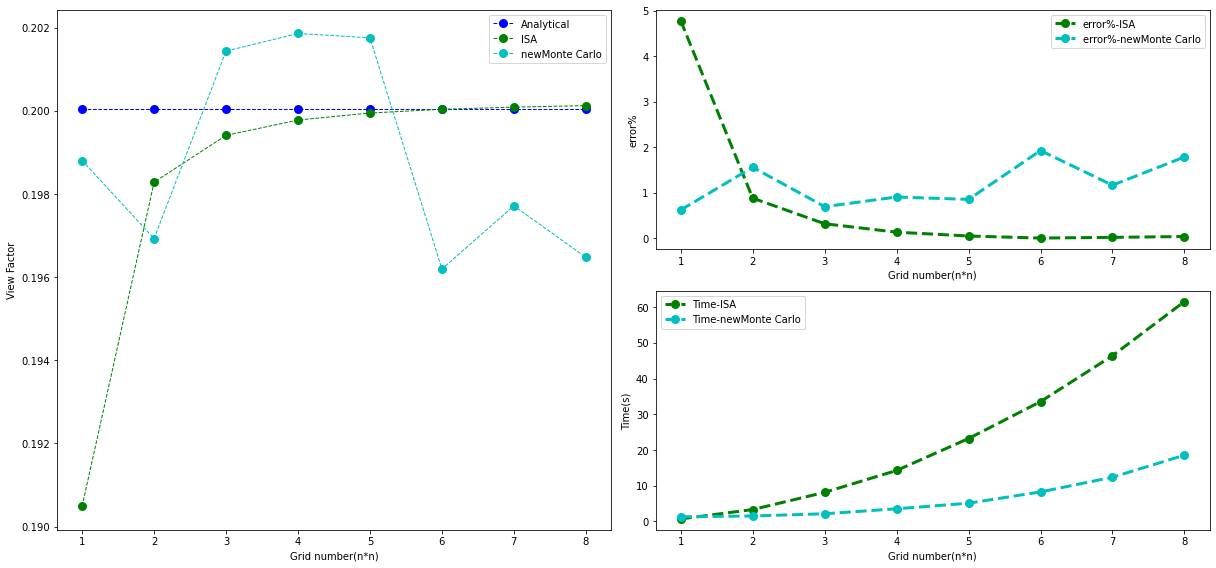

In [147]:
fig = plt.figure(figsize=(17,8))
gs = GridSpec(nrows=2,ncols=2)

ax0 = fig.add_subplot(gs[:,0])
#ax0.plot(L1,vf,'r--',label = 'Nusselt analogue',linewidth=1,marker='o',markeredgewidth=3)
ax0.plot(L3,vf_a_v,'b--',label = 'Analytical',linewidth=1,marker='o',markeredgewidth=3)
ax0.plot(L3,viewfactor,'g--',label = 'ISA',linewidth=1,marker='o',markeredgewidth=3)
#ax0.plot(L1,vf3,'y--',label = 'Monte Carlo',linewidth=1,marker='o',markeredgewidth=3)
ax0.plot(L3,vf6,'c--',label = 'newMonte Carlo',linewidth=1,marker='o',markeredgewidth=3)
ax0.set(xlabel='Grid number(n*n)',ylabel='View Factor')
plt.legend()

ax1 = fig.add_subplot(gs[0,1])
#ax1.plot(L1,error,'r--',label = 'error%-Nusselt analogue',linewidth=3,marker='o',markeredgewidth=3)
ax1.plot(L3,error5,'g--',label = 'error%-ISA',linewidth=3,marker='o',markeredgewidth=3)
#ax1.plot(L1,error3,'y--',label = 'error%-Monte Carlo',linewidth=3,marker='o',markeredgewidth=3)
ax1.plot(L3,error6,'c--',label = 'error%-newMonte Carlo',linewidth=3,marker='o',markeredgewidth=3)
ax1.set(xlabel='Grid number(n*n)',ylabel='error%')
plt.legend()

ax2 = fig.add_subplot(gs[1,1])
#ax2.plot(L1,time,'r--',label = 'Time-Nusselt analogue',linewidth=3,marker='o',markeredgewidth=3)
ax2.plot(L3,time5,'g--',label = 'Time-ISA',linewidth=3,marker='o',markeredgewidth=3)
#ax2.plot(L1,time3,'y--',label = 'Time-Monte Carlo',linewidth=3,marker='o',markeredgewidth=3)
ax2.plot(L3,time6,'c--',label = 'Time-newMonte Carlo',linewidth=3,marker='o',markeredgewidth=3)
ax2.set(xlabel='Grid number(n*n)',ylabel='Time(s)')
plt.legend()
plt.tight_layout()
plt.savefig('C:/Users/zcui/Desktop/fig/L3.png',dpi=500)

# Vertical to ground but not parallel

In [313]:
#L4 = [0.1*pi,0.2*pi,0.3*pi,0.4*pi]
L4=[pi/6]

In [318]:
#isa method
vf_isa = []
time7 =[]
for j in range(len(L4)):
    start = timeit.default_timer()
    f1,f2 = CreateFaces(1,1,'parallel')
    f2 = rotation(f2,L4[j])
    f1 = rotation(f1,-L4[j])
    d = GeoDataFrame(Subdivide2(f1.iloc[0],f2.iloc[0]))
    c = GeoDataFrame(Subdivide2(f2.iloc[0],f1.iloc[0]))
    vftest = 0
    for i in range(len(d)):
        face_0 = d.iloc[i]
        vf2_isa = [isa(face_0,face_1) for face_1 in c.iloc]
        vftest = vftest + sum(vf2_isa)/len(d)
    vf_isa.append(vftest)
    stop = timeit.default_timer()
    time7.append(stop-start)

In [319]:
#Nusselt analogue
vf_nu = []
error8 = []
time8 = []
for n in range(len(L4)):
    start = timeit.default_timer()
    vf2=[]
    f1,f2 = CreateFaces(1,1,'parallel')
    f2 = rotation(f2,L4[n])
    f1 = rotation(f1,-L4[n])
    f1_grid = grid3d(f1.geometry.squeeze(),5,5)
    f2_grid = grid3d(f2.geometry.squeeze(),5,5)
    for i in f2_grid.iloc():
        vf3=[]
        for j in f1_grid.iloc():
            vf3.append(vf_nusselt(j,i))
        vf2.append(sum(vf3)/len(f1_grid))
    vf_nu.append(sum(vf2))
    error8.append(abs(sum(vf2)-vf_isa[n])/vf_isa[n]*100)
    stop = timeit.default_timer()
    time8.append(stop-start)

ValueError: The number of FixedLocator locations (1), usually from a call to set_ticks, does not match the number of ticklabels (4).

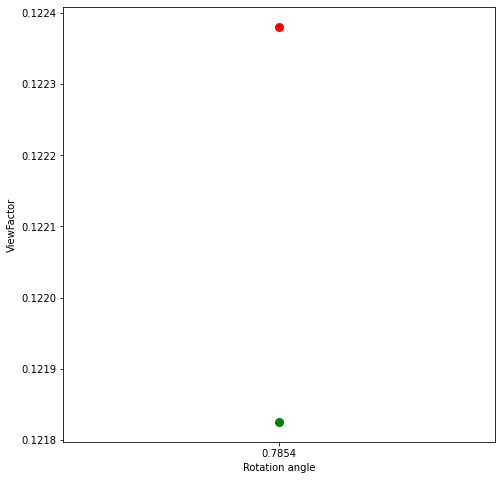

In [287]:
fig = plt.figure(figsize=(17,8))
gs = GridSpec(nrows=2,ncols=2)
group_lables = ['pi/10','pi/5','0.3pi','0.4pi']

ax0 = fig.add_subplot(gs[:,0])
ax0.plot(L4,vf_isa,'g--',label = 'ISA',linewidth=1,marker='o',markeredgewidth=3)
ax0.plot(L4,vf_nu,'r--',label = 'Nusselt analogue',linewidth=1,marker='o',markeredgewidth=3)
ax0.set(xlabel='Rotation angle',ylabel='ViewFactor')
plt.xticks(L4,group_lables,rotation=0)
plt.legend()

ax1 = fig.add_subplot(gs[0,1])
ax1.plot(L4,error8,'r--',label = 'error%-Nusselt analogue',linewidth=3,marker='o',markeredgewidth=3)
ax1.set(xlabel='Rotation angle',ylabel='error%')
plt.xticks(L4,group_lables,rotation=0)
plt.legend()

ax2 = fig.add_subplot(gs[1,1])
ax2.plot(L4,time8,'r--',label = 'Time-Nusselt analogue',linewidth=3,marker='o',markeredgewidth=3)
ax2.plot(L4,time7,'g--',label = 'Time-ISA',linewidth=3,marker='o',markeredgewidth=3)
plt.xticks(L4,group_lables,rotation=0)
ax2.set(xlabel='Rotation angle',ylabel='Time(s)')
plt.legend()
plt.tight_layout()
plt.savefig('C:/Users/zcui/Desktop/fig/L5.png',dpi=500)

In [389]:
scene1 = ToUnstructuredGrid([f5,f6]).run()
scene1.plot()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

# Share same edge

In [433]:
L5 = [0.5*pi,0.6*pi,0.7*pi,0.8*pi,0.9*pi]
#L5 = [0.5*pi,0.6*pi,0.7*pi,0.8*pi,0.9*pi]

In [434]:
vf_a=[]
for n in range(len(L5)):
    vf_a.append((1-sin(L5[n]/2)))

In [435]:
#Nusselt analogue
vf_nu = []
error9 = []
time9 = []
for n in range(len(L5)):
    f5,f6 = CreateFaces_share(L5[n])
    start = timeit.default_timer()
    vf2=[]
    f5_grid = grid3d(f5.geometry.squeeze(),5,5)
    f6_grid = grid3d(f6.geometry.squeeze(),5,5)
    for i in f6_grid.iloc():
        vf5=[]
        for j in f5_grid.iloc():
            vf5.append(vf_nusselt(j,i))
        vf2.append(sum(vf5)/len(f5_grid))
    vf_nu.append(sum(vf2))
    error9.append(abs(sum(vf2)-(1-sin(L5[n]/2)))/(1-sin(L5[n]/2))*100)
    stop = timeit.default_timer()
    time9.append(stop-start)

In [436]:
#isa method
vf_isa = []
time10 =[]
error10=[]
for n in range(len(L5)):
    start = timeit.default_timer()
    f5,f6 = CreateFaces_share(L5[n])
    d = GeoDataFrame(Subdivide2(f5.iloc[0],f6.iloc[0]))
    c = GeoDataFrame(Subdivide2(f6.iloc[0],f5.iloc[0]))
    vftest = 0
    for i in range(len(d)):
        face_0 = d.iloc[i]
        vf2_isa = [isa(face_0,face_1) for face_1 in c.iloc]
        vftest = vftest + sum(vf2_isa)/len(d)
    vf_isa.append(vftest)
    stop = timeit.default_timer()
    error10.append(abs(vftest-(1-sin(L5[n]/2)))/(1-sin(L5[n]/2))*100)
    time10.append(stop-start)

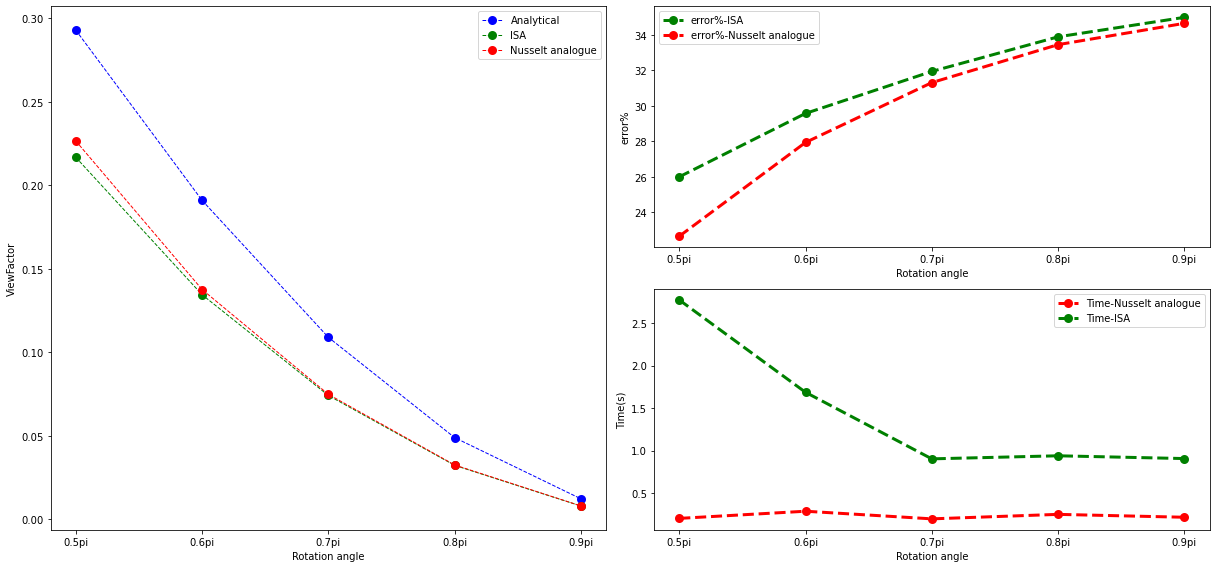

In [438]:
fig = plt.figure(figsize=(17,8))
gs = GridSpec(nrows=2,ncols=2)
group_lables = ['0.5pi','0.6pi','0.7pi','0.8pi','0.9pi']

ax0 = fig.add_subplot(gs[:,0])
ax0.plot(L5,vf_a,'b--',label = 'Analytical',linewidth=1,marker='o',markeredgewidth=3)
ax0.plot(L5,vf_isa,'g--',label = 'ISA',linewidth=1,marker='o',markeredgewidth=3)
ax0.plot(L5,vf_nu,'r--',label = 'Nusselt analogue',linewidth=1,marker='o',markeredgewidth=3)
ax0.set(xlabel='Rotation angle',ylabel='ViewFactor')
plt.xticks(L5,group_lables,rotation=0)
plt.legend()

ax1 = fig.add_subplot(gs[0,1])
ax1.plot(L5,error10,'g--',label = 'error%-ISA',linewidth=3,marker='o',markeredgewidth=3)
ax1.plot(L5,error9,'r--',label = 'error%-Nusselt analogue',linewidth=3,marker='o',markeredgewidth=3)
ax1.set(xlabel='Rotation angle',ylabel='error%')
plt.xticks(L5,group_lables,rotation=0)
plt.legend()

ax2 = fig.add_subplot(gs[1,1])
ax2.plot(L5,time9,'r--',label = 'Time-Nusselt analogue',linewidth=3,marker='o',markeredgewidth=3)
ax2.plot(L5,time10,'g--',label = 'Time-ISA',linewidth=3,marker='o',markeredgewidth=3)
plt.xticks(L5,group_lables,rotation=0)
ax2.set(xlabel='Rotation angle',ylabel='Time(s)')
plt.legend()
plt.tight_layout()
#plt.savefig('C:/Users/zcui/Desktop/fig/L5.png',dpi=500)

In [444]:
vf_mc = []
n = 4
m = 4
times = 1
n_ray = 10000
for n in range(len(L5)):
    start = timeit.default_timer()
    f5,f6 = CreateFaces_share(L5[n])
    vf = newMonteCarlo(f3,f4,n_ray,n,m,times)
    vf_mc.append(vf)
    vf6.append(vf_mc)
    stop = timeit.default_timer()
    error10.append(abs(vf-(1-sin(L5[n]/2)))/(1-sin(L5[n]/2)))

C:\Users\zcui\AppData\Local\Temp\ipykernel_10252\1899217247.py:8: RuntimeWarning: divide by zero encountered in true_divide
  vec2 = (p2-p1)/n
C:\Users\zcui\AppData\Local\Temp\ipykernel_10252\1899217247.py:8: RuntimeWarning: invalid value encountered in true_divide
  vec2 = (p2-p1)/n
C:\Users\zcui\AppData\Local\Temp\ipykernel_10252\1899217247.py:8: RuntimeWarning: divide by zero encountered in true_divide
  vec2 = (p2-p1)/n
C:\Users\zcui\AppData\Local\Temp\ipykernel_10252\1899217247.py:8: RuntimeWarning: invalid value encountered in true_divide
  vec2 = (p2-p1)/n


ValueError: Assigning CRS to a GeoDataFrame without a geometry column is not supported. Supply geometry using the 'geometry=' keyword argument, or by providing a DataFrame with column name 'geometry'

In [449]:
1-sin(pi/4/2)

0.6173165676349102